## Is it possible to predict how betting odds will change, by using predicted polling data?

In [2]:
import requests
import numpy as np
import pandas as pd
from realclearpolling import *

In [3]:
url = 'https://www.realclearpolitics.com/json/odds/event_106_final.json?'
response = requests.get(url)
data = response.json()
print(data)

{'poll': {'rcp_avg': [{'date_r': 'Sun, 03 Mar 2024 00:00:00 -0500', 'candidates': [{'id': '2081', 'name': 'Donald Trump', 'color': '#d30015', 'value': '44.8'}, {'id': '2090', 'name': 'Joe Biden', 'color': '#0a0ab2', 'value': '28.0'}, {'id': '2244', 'name': 'Michelle Obama', 'color': '#c3c3de', 'value': '9.0'}, {'id': '2094', 'name': 'Gavin Newsom', 'color': '#7381C9', 'value': '6.0'}, {'id': '2473', 'name': 'Robert Kennedy Jr', 'color': '#993300', 'value': '3.7'}, {'id': '2086', 'name': 'Nikki Haley', 'color': '#bf40b0', 'value': '3.6'}, {'id': '2092', 'name': 'Kamala Harris', 'color': '#00e4ff', 'value': '3.4'}, {'id': '2564', 'name': 'Dean Phillips', 'color': '#37aac7', 'value': '0.5'}, {'id': '2451', 'name': 'Vivek Ramaswamy', 'color': '#3da882', 'value': '0.0'}]}, {'date_r': 'Sat, 02 Mar 2024 00:00:00 -0500', 'candidates': [{'id': '2081', 'name': 'Donald Trump', 'color': '#d30015', 'value': '44.0'}, {'id': '2090', 'name': 'Joe Biden', 'color': '#0a0ab2', 'value': '27.0'}, {'id': '2

In [4]:
def get_candidate_odds(data, candidate):
    nlist = []
    for i in range(len(data)):
        values = data[i]['candidates']
        for value in values:
            if value['name'] == candidate:
                nlist.append(value['value'])
    return nlist 

def get_dates(data):
    nlist = []
    for i in range(len(data)):
        nlist.append(data[i]['date_r'])
    return nlist

dates = get_dates(data['poll']['rcp_avg'])
trump_odds = get_candidate_odds(data['poll']['rcp_avg'], 'Donald Trump')
biden_odds = get_candidate_odds(data['poll']['rcp_avg'], 'Joe Biden')

In [5]:
# Make a dataframe with dates, Trump odds, Biden odds
df = pd.DataFrame({'date': dates, 'trump': trump_odds, 'biden': biden_odds})
df['date'] = pd.to_datetime(df['date'],utc=True)
df['date'] = df['date'].dt.date
df['biden_rolling'] = df['biden'].rolling(window=1).mean()
df['trump_rolling'] = df['trump'].rolling(window=1).mean()
df.sort_values(by='date', inplace=True)

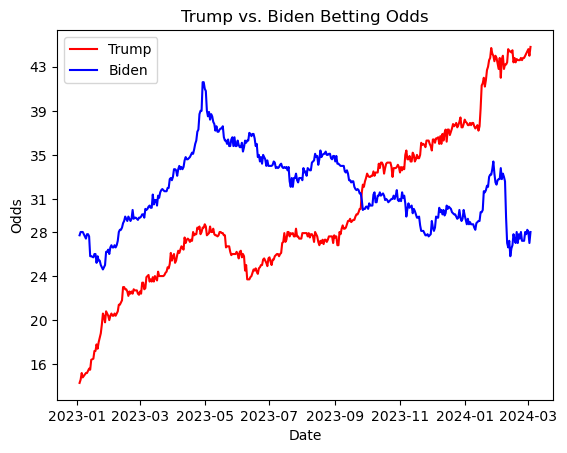

In [6]:
# Plot the odds as a time series
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots()

# Use AutoDateLocator to set a reasonable date format
ax.yaxis.set_major_locator(mdates.AutoDateLocator())
plt.plot(df['date'], np.array(df['trump_rolling']), label='Trump',color = 'red')
plt.plot(df['date'], np.array(df['biden_rolling']), label='Biden', color = 'blue')
ax.set_xlabel('Date')
ax.set_ylabel('Odds')
ax.set_title('Trump vs. Biden Betting Odds')
ax.legend()
plt.show()

In [7]:
rcp = clean_data(get_poll_data())
rcp.head()

,pollster,date,sample,moe,Trump (R),Biden (D),spread,Difference,Type of Voter,Sample Size,End Date,Poll Month,Year,Days Since 01-01-23
0,CBS News,2/28 - 3/1,1436 RV,—,52.0,48.0,Trump+4,4.0,RV,1436,2024-03-01,3,2024,425
1,FOX News,2/25 - 2/28,1262 RV,2.5,49.0,47.0,Trump+2,2.0,RV,1262,2024-02-28,2,2024,423
2,Wall Street Journal,2/21 - 2/28,1500 RV,2.5,47.0,45.0,Trump+2,2.0,RV,1500,2024-02-28,2,2024,423
3,NY Times/Siena,2/25 - 2/28,980 LV,3.5,48.0,44.0,Trump+4,4.0,LV,980,2024-02-28,2,2024,423
4,Forbes/HarrisX,2/24 - 2/28,3021 RV,1.8,52.0,48.0,Trump+4,4.0,RV,3021,2024-02-28,2,2024,423


In [8]:
# Plot polling data on a time series

#Is it possible to subset the predictions to only include the unique dates?
dates = rcp["End Date"]
unique_dates = np.unique(dates)

biden_vals = []
trump_vals = []

for date in unique_dates:
    mask = rcp["End Date"] == date
    biden_vals.append(rcp[mask]["Biden (D)"].mean())
    trump_vals.append(rcp[mask]["Trump (R)"].mean())

ndf = pd.DataFrame({'date': unique_dates, 'trump': trump_vals, 'biden': biden_vals})
ndf["Biden Rolling"] = ndf["biden"].rolling(window=5).mean()
ndf["Trump Rolling"] = ndf["trump"].rolling(window=5).mean()
ndf.sort_values(by='date', inplace=True)
ndf.head()



,date,trump,biden,Biden Rolling,Trump Rolling
0,2023-01-16,40.0,46.0,NaN,NaN
1,2023-01-17,42.0,46.0,NaN,NaN
2,2023-01-19,46.0,41.0,NaN,NaN
3,2023-01-20,43.0,40.0,NaN,NaN
4,2023-01-21,44.0,41.0,42.8,43.0


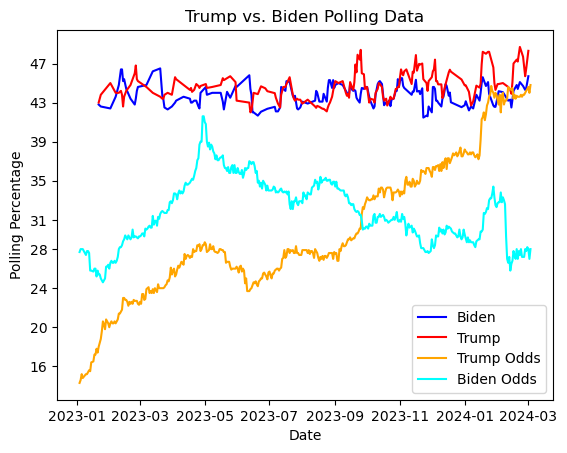

In [9]:
fig, ax = plt.subplots()
ax.yaxis.set_major_locator(mdates.AutoDateLocator())
plt.plot(unique_dates, ndf['Biden Rolling'], label='Biden',color = 'blue')
plt.plot(unique_dates, ndf['Trump Rolling'], label='Trump', color = 'red')
plt.plot(df['date'], np.array(df['trump_rolling']), label='Trump Odds',color = 'orange')
plt.plot(df['date'], np.array(df['biden_rolling']), label='Biden Odds', color = 'aqua')
ax.set_xlabel('Date')
ax.set_ylabel('Polling Percentage')
ax.set_title('Trump vs. Biden Polling Data')
ax.legend()
plt.show()

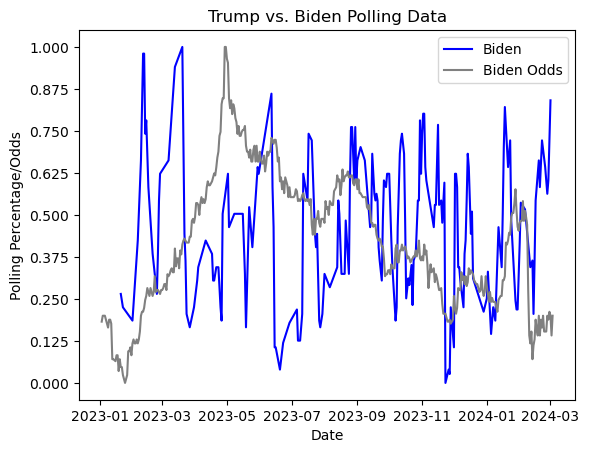

In [13]:
# We should try to rescale the data to be between 0 and 1

# We can use the min-max scaling method to rescale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
ndf['Biden Rolling'] = scaler.fit_transform(ndf['Biden Rolling'].values.reshape(-1,1))
ndf['Trump Rolling'] = scaler.fit_transform(ndf['Trump Rolling'].values.reshape(-1,1))
df['biden_rolling'] = scaler.fit_transform(df['biden_rolling'].values.reshape(-1,1))
df['trump_rolling'] = scaler.fit_transform(df['trump_rolling'].values.reshape(-1,1))

fig, ax = plt.subplots()
ax.yaxis.set_major_locator(mdates.AutoDateLocator())
plt.plot(unique_dates, ndf['Biden Rolling'], label='Biden',color = 'blue')
#plt.plot(unique_dates, ndf['Trump Rolling'], label='Trump', color = 'red')
#plt.plot(df['date'], np.array(df['trump_rolling']), label='Trump Odds',color = 'orange')
plt.plot(df['date'], np.array(df['biden_rolling']), label='Biden Odds', color = 'grey')
ax.set_xlabel('Date')
ax.set_ylabel('Polling Percentage/Odds')
ax.set_title('Trump vs. Biden Polling Data')
ax.legend()
plt.show()

## General Observations

It looks like the odds precurse the polls. This makes sense, since odds are based on real time news updates, and polls face lag effects. 